В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [484]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
%matplotlib notebook
%matplotlib inline

In [485]:
X = pd.read_csv('weather.csv')
X.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [486]:
X = X.replace({'No':0, 'Yes': 1})
y = X.RainTomorrow
del X['RainTomorrow']
del X['Unnamed: 0']

In [487]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [488]:
X.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
dtype: int64

In [489]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=10, shuffle=False)

In [490]:
X_train['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany'], dtype=object)

In [491]:
X_test['Location'].unique()

array(['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth',
       'SalmonGums', 'Walpole', 'Hobart', 'Launceston', 'AliceSprings',
       'Darwin', 'Katherine', 'Uluru'], dtype=object)

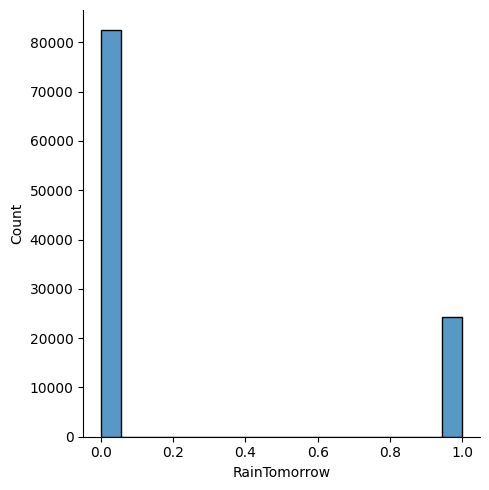

In [492]:
sns.displot(y_train)

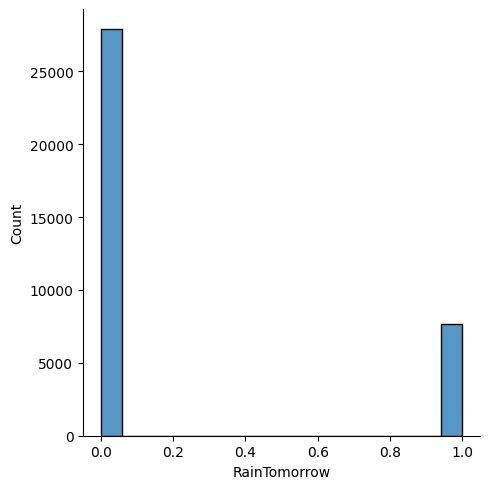

In [493]:
sns.displot(y_test)

In [494]:
y_train.value_counts() / len(y_train)

0    0.772983
1    0.227017
Name: RainTomorrow, dtype: float64

In [495]:
y_test.value_counts() / len(y_test)

0    0.784326
1    0.215674
Name: RainTomorrow, dtype: float64

In [496]:
X['Date'] = pd.to_datetime(X['Date'])

In [497]:
def get_season_number(datetime):
    month = datetime.month
    if month == 12 or month < 3:
        return 0
    if 3 <= month < 6:
        return 1
    if 9 <= month < 12:
        return 2
    return 3

In [498]:
def get_loc_and_season(row):
    return row['Location'] + ' ' + str(get_season_number(row['Date']))

In [499]:
X['Loc&Season'] = X.apply(get_loc_and_season, axis=1)

In [500]:
del X['Location']
del X['Date']

In [501]:
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Loc&Season
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,Albury 0
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,Albury 0
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,Albury 0
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,Albury 0
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,Albury 0


In [502]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False)

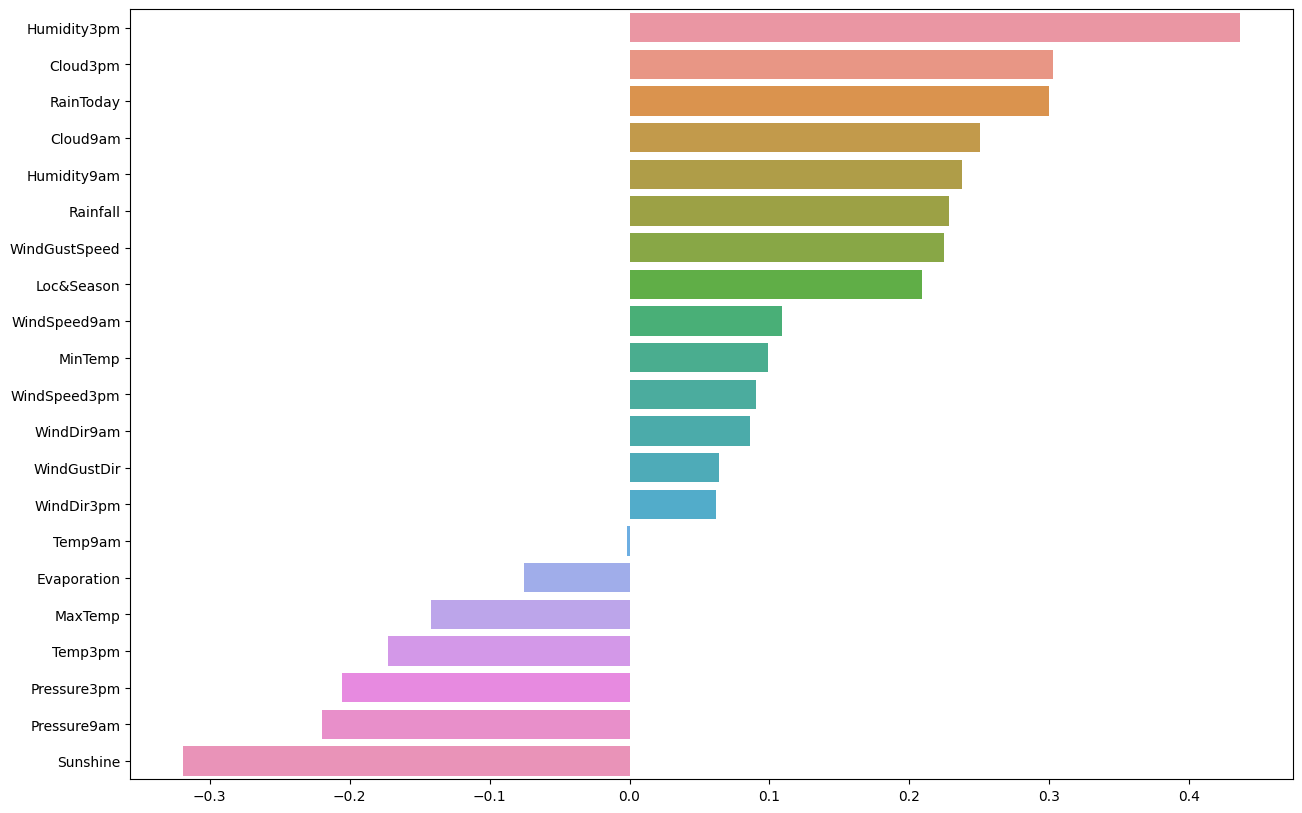

In [503]:
X_mean = X.mean()

X_train = X_train.fillna(X_mean)
X_test = X_test.fillna(X_mean)

correlations = WOEEncoder().fit_transform(X_train, y_train).corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)
plot.figure.show()

In [505]:
logreg_model = make_pipeline(
    WOEEncoder(),
    StandardScaler(),
    LogisticRegression()
)

In [506]:
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
y_train_pred = logreg_model.predict(X_train)

In [507]:
roc_auc_score(y_test, y_pred)

0.704957705874204

In [508]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     27882
           1       0.76      0.45      0.56      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.70      0.74     35549
weighted avg       0.84      0.85      0.84     35549



In [509]:
roc_auc_score(y_train, y_train_pred)

0.7157637987525689

In [510]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     82434
           1       0.71      0.49      0.58     24210

    accuracy                           0.84    106644
   macro avg       0.79      0.72      0.74    106644
weighted avg       0.83      0.84      0.83    106644



In [511]:
knn_model = make_pipeline(
    WOEEncoder(),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

In [512]:
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
y_train_pred = knn_model.predict(X_train)

In [513]:
roc_auc_score(y_test, y_pred)

0.6793046053227334

In [514]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.90     27882
           1       0.66      0.42      0.51      7667

    accuracy                           0.83     35549
   macro avg       0.76      0.68      0.70     35549
weighted avg       0.81      0.83      0.81     35549



In [515]:
roc_auc_score(y_train, y_train_pred)

0.7780082531723249

In [516]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     82434
           1       0.82      0.60      0.69     24210

    accuracy                           0.88    106644
   macro avg       0.85      0.78      0.81    106644
weighted avg       0.87      0.88      0.87    106644



In [517]:
bayes_model = make_pipeline(
    WOEEncoder(),
    StandardScaler(),
    GaussianNB()
)

In [518]:
bayes_model.fit(X_train, y_train)
y_pred = bayes_model.predict(X_test)
y_train_pred = bayes_model.predict(X_train)

In [519]:
roc_auc_score(y_test, y_pred)

0.7429277712095432

In [520]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     27882
           1       0.62      0.58      0.60      7667

    accuracy                           0.83     35549
   macro avg       0.75      0.74      0.75     35549
weighted avg       0.83      0.83      0.83     35549



In [521]:
roc_auc_score(y_train, y_train_pred)

0.7309061067336089

In [522]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     82434
           1       0.56      0.60      0.58     24210

    accuracy                           0.80    106644
   macro avg       0.72      0.73      0.72    106644
weighted avg       0.81      0.80      0.80    106644



### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [523]:
theta = np.array([1, 2, 3])

X_check =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y_check = np.array([1, 1, 0, 0])

In [524]:
def probability(theta, X):
    return 1 / (1 + np.exp(-np.dot(X, theta)))
prob = probability(theta, X_check)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X_check.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [525]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    return prob >= threshold

y_pred = binary_class_prediction(theta, X_check)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X_check.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [526]:
def logloss(theta, X, y): 
    prob = probability(theta, X)
    return - ((y * np.log(prob) + (1 - y) * np.log(1 - prob)) / len(y)).sum()

In [527]:
assert logloss(theta, X_check, y_check).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [528]:
def gradient(theta, X, y):
    # YOUR CODE HERE
    prob = probability(theta, X)
    return X.transpose() @ (prob - y)

assert gradient(theta, X_check, y_check).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [529]:
def get_theta(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]


        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [530]:
class MyLogReg():
    def fit(self, X, y):
        self.theta = get_theta(X, y)
    def predict(self, X):
        return binary_class_prediction(self.theta, X)

In [531]:
mylogreg_model = make_pipeline(
    WOEEncoder(),
    StandardScaler(),
    MyLogReg()
)

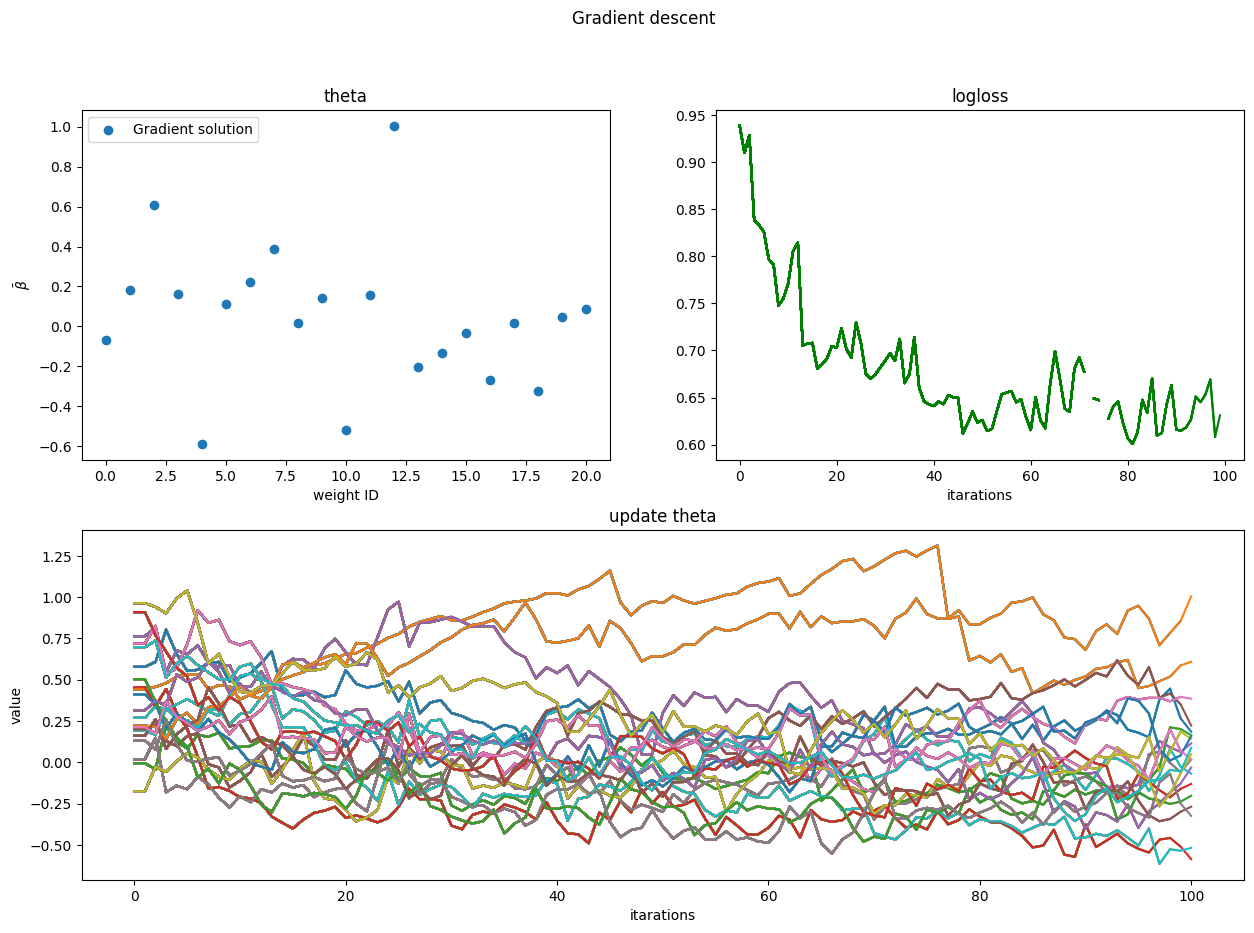

In [532]:
mylogreg_model.fit(X_train, y_train)
y_pred = mylogreg_model.predict(X_test)
y_train_pred = mylogreg_model.predict(X_train)

In [533]:
roc_auc_score(y_test, y_pred)

0.7708662511066617

In [534]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80     27882
           1       0.44      0.84      0.57      7667

    accuracy                           0.73     35549
   macro avg       0.69      0.77      0.69     35549
weighted avg       0.83      0.73      0.76     35549



In [535]:
roc_auc_score(y_train, y_train_pred)

0.7284075813089358

In [536]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     82434
           1       0.41      0.79      0.54     24210

    accuracy                           0.69    106644
   macro avg       0.66      0.73      0.65    106644
weighted avg       0.80      0.69      0.72    106644



Анализ

Все использованные методы показали приблизительно одинаковую точность. Но у каждого есть свои особенности.

1. Метод ближайших соседей работает долго и склонен к переобучению

2. Байесовский классификатор работает отлично как по времени, так и по точности

3. Библиотечная логистическая регрессия сработала немного хуже Байесовского классификатора, но обеспечила одинаковую точность, как на трейне, так и на тесте

4. Самописная логистическая регрессия работает намного дольше библиотечной, но при должном подборе параметров может показать такую же точность, но не обеспечивает стабильность результата